In [2]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [64]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

## Cleaning

    Remove punctuation, tokenize, remove stopwords

In [4]:
data = pd.read_csv("SMSSpamCollection.tsv", sep='\t')
data.columns = ['label', 'body_text']

In [5]:
data.head()

,label,body_text
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...
1,ham,"Nah I don't think he goes to usf, he lives aro..."
2,ham,Even my brother is not like to speak with me. ...
3,ham,I HAVE A DATE ON SUNDAY WITH WILL!!
4,ham,As per your request 'Melle Melle (Oru Minnamin...


In [6]:
def remove_punctuation(text):
    tmp_list = []
    for ch in text:
        if ch not in string.punctuation:
            tmp_list.append(ch)    
    return "".join(tmp_list)

In [7]:
test = "hello, world!"
remove_punctuation(test)

'hello world'

In [8]:
def tokenize(text):
    return re.split("\W+", text.lower()) # capital W means non-word character [^a-zA-Z0-9_] 

In [9]:
tokenize(test)

['hello', 'world', '']

In [10]:
def remove_stopWord(textList):
    res = []
    stopwords = nltk.corpus.stopwords.words('english')
    for word in textList:
        if word not in stopwords:
            res.append(word)
    return res

In [11]:
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [12]:
test1 = "I say that, Hello world"
test1 = remove_punctuation(test1)
test1 = tokenize(test1)
test1 = remove_stopWord(test1)
print(test1)

['say', 'hello', 'world']


In [13]:
def clean(text):
    res = remove_punctuation(text)
    res = tokenize(res)
    res = remove_stopWord(res)
    return res

In [14]:
test1 = "I say that, Hello world"
clean(test1)

['say', 'hello', 'world']

In [15]:
data['body_text_cleaned'] = data['body_text'].apply(lambda x : clean(x))

In [16]:
data.head()

,label,body_text,body_text_cleaned
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
1,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, goes, usf, lives, around, t..."
2,ham,Even my brother is not like to speak with me. ...,"[even, brother, like, speak, treat, like, aids..."
3,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,"[date, sunday]"
4,ham,As per your request 'Melle Melle (Oru Minnamin...,"[per, request, melle, melle, oru, minnaminungi..."


## Stemming

    In linguistic morphology and information retrieval, stemming is the process of reducing inflected words to their word stem, base or root form—generally a written word form. Here not use lemmatization because lemmatization needs more time to process although it is more accurate.

In [17]:
def stemming(textList):
    ps = nltk.PorterStemmer()
    res = []
    for word in textList:
        word_stemmed = ps.stem(word)
        res.append(word_stemmed)
    return res

In [18]:
data['body_text_cleaned_stemmed'] = data['body_text_cleaned'].apply(lambda x : stemming(x))

In [19]:
data.head()

,label,body_text,body_text_cleaned,body_text_cleaned_stemmed
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin..."
1,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho..."
2,ham,Even my brother is not like to speak with me. ...,"[even, brother, like, speak, treat, like, aids...","[even, brother, like, speak, treat, like, aid,..."
3,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,"[date, sunday]","[date, sunday]"
4,ham,As per your request 'Melle Melle (Oru Minnamin...,"[per, request, melle, melle, oru, minnaminungi...","[per, request, mell, mell, oru, minnaminungint..."


## TF-IDF

    TF-IDF (term frequency inverse document frequency), it gnerates a matrix, each cell in the matrix is the weight of the word to the text, indicating how important a word is to individual text message, the rarer the word is the higher the weight is.

In [25]:
def clean_stem(text):
    resList = clean(text)
    resList = stemming(resList)
    return resList

In [28]:
tfidf_vect = TfidfVectorizer(analyzer = clean_stem)
X_tfidf = tfidf_vect.fit_transform(data['body_text'])
print(X_tfidf.shape)

(5567, 8104)


    TfidfVectorizer is to analyse corpus like the following one.
    corpus = ["this artical is about scikit-learn vectorizor",
          "do you like it",
          "if you like it, please click favorite"]
    So we cannot apply TfidfVectorizer directly to the cleaned and stemmed text list, here we could pass the clean and stem function to the "analyzer" argument in TfidfVectorizer. 

In [29]:
X_tfidf

<5567x8104 sparse matrix of type '<class 'numpy.float64'>'
	with 50122 stored elements in Compressed Sparse Row format>

In [33]:
X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
X_tfidf_df.columns = tfidf_vect.get_feature_names()
print("Print the first 6 rows and 6 columns of the sparse TF-IDF matrix")
X_tfidf_df[0:6][0:6]

Print the first 6 rows and 6 columns of the sparse TF-IDF matrix


,,0,008704050406,0089mi,0121,01223585236,01223585334,0125698789,02,020603,...,zindgi,zoe,zogtoriu,zoom,zouk,zyada,é,ü,üll,〨ud
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Classification with Random Forest

In [35]:
rf = RandomForestClassifier()
params = {"n_estimators" : [10, 50, 100],
          "max_depth" : [30, 60, 90, None]}
gs = GridSearchCV(rf, params, cv = 5, n_jobs = -1)
gs_fit = gs.fit(X_tfidf_df, data["label"])
pd.DataFrame(gs_fit.cv_results_).sort_values("mean_test_score", ascending = False)[0:5]

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
10,38.681293,1.435373,0.302184,0.030274,None,50,"{'max_depth': None, 'n_estimators': 50}",0.977578,0.974843,0.973944,...,0.972696,0.003763,1,0.999551,0.999775,1.000000,0.999775,0.999775,0.999775,0.000142
7,33.782308,1.030880,0.447420,0.214816,90,50,"{'max_depth': 90, 'n_estimators': 50}",0.977578,0.972147,0.975741,...,0.972517,0.003720,2,0.997754,0.997755,0.998428,0.997979,0.997979,0.997979,0.000246
8,68.638447,3.074433,0.492471,0.094485,90,100,"{'max_depth': 90, 'n_estimators': 100}",0.977578,0.971249,0.973944,...,0.971978,0.003489,3,0.998652,0.997530,0.998428,0.998428,0.997755,0.998159,0.000435
6,7.969343,0.327695,0.153884,0.025564,90,10,"{'max_depth': 90, 'n_estimators': 10}",0.973094,0.973046,0.975741,...,0.971798,0.003297,4,0.996631,0.995734,0.998204,0.997306,0.997306,0.997036,0.000821
11,64.547500,12.179075,0.380794,0.157163,None,100,"{'max_depth': None, 'n_estimators': 100}",0.978475,0.974843,0.968553,...,0.971798,0.004174,4,1.000000,1.000000,1.000000,1.000000,0.999775,0.999955,0.000090


/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

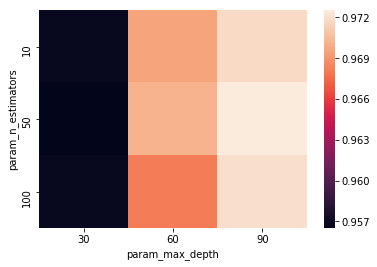

In [37]:
pvt = pd.pivot_table(pd.DataFrame(gs.cv_results_),
                     values = "mean_test_score",
                     index = "param_n_estimators",
                     columns = "param_max_depth")
import seaborn as sns       
ax = sns.heatmap(pvt)

In [39]:
print("Best cross_validation score: {:.2f}".format(gs.best_score_))
print("Best parameters: ", gs.best_params_)

Best cross_validation score: 0.97
Best parameters:  {'max_depth': None, 'n_estimators': 50}


## Classification with Gradient Boosting

In [41]:
gb = GradientBoostingClassifier()
params = {
    "n_estimators": [100, 150], 
    "max_depth": [7, 11, 15],
    #"learning_rate": [0.1], here learning rate use the default value 0.1
}
gs_gb = GridSearchCV(gb, params, cv = 5, n_jobs = -1)
gs_gb_fit = gs_gb.fit(X_tfidf_df, data["label"])
pd.DataFrame(gs_gb_fit.cv_results_).sort_values("mean_test_score", ascending = False)[0:5]

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,1400.905717,208.183181,0.253287,0.099867,7,150,"{'max_depth': 7, 'n_estimators': 150}",0.965919,0.975741,0.965858,...,0.967487,0.004186,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
0,835.215623,3.979630,0.194962,0.014207,7,100,"{'max_depth': 7, 'n_estimators': 100}",0.968610,0.972147,0.968553,...,0.967128,0.003489,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5,2473.087985,406.575524,0.210866,0.051401,15,150,"{'max_depth': 15, 'n_estimators': 150}",0.968610,0.974843,0.964960,...,0.966768,0.004792,3,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,1918.949689,36.858645,0.241209,0.066082,11,150,"{'max_depth': 11, 'n_estimators': 150}",0.967713,0.974843,0.964960,...,0.966589,0.004597,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,1513.979204,169.497869,0.275804,0.081739,11,100,"{'max_depth': 11, 'n_estimators': 100}",0.964126,0.975741,0.964960,...,0.966050,0.004928,5,1.0,1.0,1.0,1.0,1.0,1.0,0.0


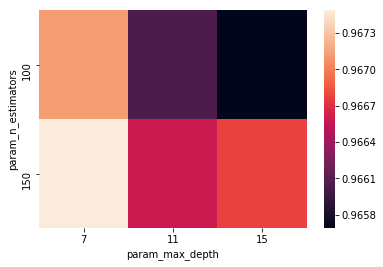

In [42]:
pvt_gb = pd.pivot_table(pd.DataFrame(gs_gb.cv_results_),
                     values = "mean_test_score",
                     index = "param_n_estimators",
                     columns = "param_max_depth")
import seaborn as sns       
ax = sns.heatmap(pvt_gb)

In [43]:
print("Best cross_validation score: {:.2f}".format(gs_gb.best_score_))
print("Best parameters: ", gs_gb.best_params_)

Best cross_validation score: 0.97
Best parameters:  {'max_depth': 7, 'n_estimators': 150}


## Compare Two Models by Printing Out Metrics

In [45]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import time

In [46]:
X_train, X_test, y_train, y_test = train_test_split(data["body_text"], data["label"], test_size = 0.2)

In [50]:
X_train.head()

4181               I'm good. Have you registered to vote?
4897         Taka lor. Wat time u wan 2 come n look 4 us?
3581    Heart is empty without love.. Mind is empty wi...
5313    Good morning, my Love ... I go to sleep now an...
3465    All day working day:)except saturday and sunday..
Name: body_text, dtype: object

In [58]:
X_train[:].head()

4181               I'm good. Have you registered to vote?
4897         Taka lor. Wat time u wan 2 come n look 4 us?
3581    Heart is empty without love.. Mind is empty wi...
5313    Good morning, my Love ... I go to sleep now an...
3465    All day working day:)except saturday and sunday..
Name: body_text, dtype: object

In [60]:
tfidf_vect = TfidfVectorizer(analyzer = clean_stem)
tfidf_vect_fit = tfidf_vect.fit(X_train[:]) # learn volcabulary and idf from the training set
X_tfidf_train = tfidf_vect_fit.transform(X_train[:]) # return term-document matrix
X_tfidf_test = tfidf_vect_fit.transform(X_test[:])
X_tfidf_train_df = pd.DataFrame(X_tfidf_train.toarray()) # transform to pd dataframe
X_tfidf_test_df = pd.DataFrame(X_tfidf_test.toarray())

In [61]:
rf_best = RandomForestClassifier(n_estimators = 50, max_depth = None, n_jobs = -1)
rf_best_model = rf_best.fit(X_tfidf_train_df, y_train)
y_pred = rf_best_model.predict(X_tfidf_test_df)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label = "spam", average = "binary")
print("Random forest classifier metrics")
print("Precision: {} / Recall: {} / Accuracy: {}".format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Random forest classifier metrics
Precision: 1.0 / Recall: 0.744 / Accuracy: 0.963


In [63]:
gb_best = GradientBoostingClassifier(n_estimators = 150, max_depth = 7)
gb_best_model = gb_best.fit(X_tfidf_train_df, y_train)
y_pred = gb_best_model.predict(X_tfidf_test_df)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label = "spam", average = "binary")
print("Gradient boosting classifier metrics")
print("Precision: {} / Recall: {} / Accuracy: {}".format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Gradient boosting classifier metrics
Precision: 0.953 / Recall: 0.756 / Accuracy: 0.96


    Random forest has better precision, (precision = TP / (TP + FP)), meaning that the FP false positive is small, here precision = 1.0, meaning no FP, all the email that is classified as "spam" are actually "spam".

    Gradient boosting has better recall, (recall = TP / (TP + FN)), representing the completeness of the model, better recall means the model is more sensitive.
    
    Although random forest and gradient boosting are tree based methods, random forest could be done in parallel, it is faster, but since gradient boosting relies on the result of the tree before it in order to apply higher weight to the ones that the previous tree got incorrect, gradient boosting can only be done iteratively, it is much slower.